<a href="https://colab.research.google.com/github/jalevano/tfm_uoc_datascience/blob/main/03_Yolo_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO TFM: Evaluación Comparativa de Técnicas de Segmentación para Fotografía de Personas

## NOTEBOOK 3: YOLOv8-seg - Evaluación Completa

**AUTOR:** Jesús L. **FECHA:** Agosto 2025.

---

## USANDO YOLOv8-seg - SEGMENTACIÓN EN TIEMPO REAL (2023)

• Arquitectura CSPDarknet53 optimizada  
• Detección y segmentación unificadas  
• Múltiples variantes de modelo (nano a xlarge)  
• Velocidad superior: 3.3ms de inferencia  

## OBJETIVOS DE ESTE NOTEBOOK:

• Implementar YOLOv8-seg para segmentación de personas  
• Evaluar diferentes tamaños de modelo (n, s, m, l, x)  
• Analizar trade-offs velocidad vs precisión  
• Comparar rendimiento en contextos fotográficos diversos  
• Generar datos comparables con MaskDINO y SAM 2.0  

---

## ESTRUCTURA:

1. **Setup e instalación de YOLOv8-seg**
2. **Configuración de variantes del modelo**
3. **Implementación con diferentes configuraciones**
4. **Evaluación especializada para fotografía de personas**
5. **Análisis de trade-offs velocidad vs calidad**
6. **Análisis de resultados y exportación de datos**



In [1]:
# Instalación de dependencias para YOLOv8-seg

# Instalar ultralytics (incluye YOLOv8)
!pip install ultralytics

# Instalar dependencias adicionales si es necesario
!pip install opencv-python-headless
!pip install matplotlib

## Verificamos la instalación.
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("Ejecutando en CPU")

print("\nInstalación completada")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
import time
import json
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
import matplotlib.pyplot as plt
import logging

# Configuración del sistema de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
class YOLOv8PersonSegmentation:
    """
    Implementación de YOLOv8-seg para segmentación de personas.

    Esta clase proporciona una interfaz para cargar diferentes
    variantes de YOLOv8-seg y realizar segmentación específica de personas
    en imágenes fotográficas.
    """

    def __init__(self, model_size: str = "m", confidence_threshold: float = 0.5):
        """
        Inicializa el modelo YOLOv8-seg con la configuración especificada.

        Args:
            model_size (str): Tamaño del modelo a cargar. Opciones: 'n', 's', 'm', 'l', 'x'
                             donde 'n' es el más rápido y 'x' el más preciso
            confidence_threshold (float): Umbral de confianza para las detecciones (0.0 - 1.0)
        """
        self.model_size = model_size
        self.confidence_threshold = confidence_threshold
        self.device = self._setup_device()
        self.model = None
        self.model_info = {}

        # Inicializar modelo
        self._load_model()

        logger.info(f"YOLOv8{model_size}-seg inicializado en {self.device}")

    def _setup_device(self) -> str:
        """
        Configura automáticamente el dispositivo disponible.

        Returns:
            str: 'cuda' si GPU disponible, 'cpu' en caso contrario
        """
        if torch.cuda.is_available():
            device_name = torch.cuda.get_device_name(0)
            logger.info(f"GPU detectada: {device_name}")
            return "cuda"
        else:
            logger.info("GPU no disponible, usando CPU")
            return "cpu"

    def _load_model(self):
        """
        Carga el modelo YOLOv8-seg desde los pesos preentrenados.
        El modelo se descarga automáticamente si no existe localmente.
        """
        try:
            model_name = f"yolov8{self.model_size}-seg.pt"
            logger.info(f"Cargando modelo {model_name}")

            # Cargar modelo preentrenado
            self.model = YOLO(model_name)

            # Mover a GPU si está disponible
            if self.device == "cuda":
                self.model.to('cuda')

            # Almacenar información del modelo
            self.model_info = {
                'name': f'YOLOv8{self.model_size}-seg',
                'device': self.device,
                'confidence_threshold': self.confidence_threshold,
                'input_size': 640,  # Resolución de entrada estándar
                'mask_resolution': 160  # Resolución de máscaras de salida
            }

            logger.info(f"Modelo {self.model_info['name']} cargado correctamente")

        except Exception as e:
            logger.error(f"Error al cargar el modelo: {e}")
            raise RuntimeError(f"No se pudo inicializar YOLOv8-seg: {e}")

    def predict(self, image: np.ndarray) -> Dict[str, Any]:
        """
        Realiza segmentación de personas en una imagen.

        Args:
            image (np.ndarray): Imagen en formato BGR (OpenCV estándar)

        Returns:
            Dict[str, Any]: Diccionario con resultados de segmentación conteniendo:
                - masks: Máscara combinada de todas las personas (np.ndarray)
                - boxes: Lista de bounding boxes con información de confianza
                - person_count: Número de personas detectadas
                - inference_time: Tiempo de procesamiento en segundos
                - fps: Frames por segundo equivalentes
        """
        if self.model is None:
            raise RuntimeError("Modelo no inicializado")

        # Validar entrada
        if not isinstance(image, np.ndarray) or len(image.shape) != 3:
            raise ValueError("La imagen debe ser un array numpy de 3 dimensiones (H, W, C)")

        # Medir tiempo de inferencia
        start_time = time.time()

        # Ejecutar inferencia
        results = self.model(image, conf=self.confidence_threshold, verbose=False)

        inference_time = time.time() - start_time

        # Procesar resultados
        processed_results = self._process_results(results[0], image.shape, inference_time)

        return processed_results

    def _process_results(self, result, image_shape: Tuple[int, int, int], inference_time: float) -> Dict[str, Any]:
        """
        Procesa los resultados brutos de YOLOv8 para extraer información de personas.

        Args:
            result: Resultado directo del modelo YOLOv8
            image_shape (Tuple): Dimensiones de la imagen original (H, W, C)
            inference_time (float): Tiempo de inferencia medido

        Returns:
            Dict[str, Any]: Resultados procesados y estructurados
        """
        height, width = image_shape[:2]

        # Inicializar estructura de resultados
        output = {
            'masks': np.zeros((height, width), dtype=np.uint8),
            'boxes': [],
            'person_count': 0,
            'inference_time': inference_time,
            'fps': 1.0 / inference_time if inference_time > 0 else 0,
            'has_detections': False
        }

        # Verificar si existen detecciones
        if result.boxes is None or len(result.boxes) == 0:
            return output

        # Filtrar solo detecciones de personas (clase 0 en COCO dataset)
        classes = result.boxes.cls.cpu().numpy()
        person_indices = np.where(classes == 0)[0]

        if len(person_indices) == 0:
            return output

        # Procesar máscaras y bounding boxes de personas
        if result.masks is not None and len(result.masks) > 0:
            masks_data = result.masks.data.cpu().numpy()
            boxes_data = result.boxes.xyxy.cpu().numpy()
            scores_data = result.boxes.conf.cpu().numpy()

            for i, idx in enumerate(person_indices):
                # Procesar máscara de segmentación
                mask = masks_data[idx]

                # Redimensionar máscara a tamaño original de imagen
                mask_resized = cv2.resize(
                    mask.astype(np.float32),
                    (width, height),
                    interpolation=cv2.INTER_LINEAR
                )

                # Binarizar máscara y asignar ID único
                mask_binary = (mask_resized > 0.5).astype(np.uint8)
                person_id = i + 1
                output['masks'][mask_binary > 0] = person_id

                # Extraer información del bounding box
                bbox = boxes_data[idx]
                confidence = scores_data[idx]

                output['boxes'].append({
                    'coordinates': bbox.tolist(),  # [x1, y1, x2, y2]
                    'confidence': float(confidence),
                    'person_id': person_id
                })

        output['person_count'] = len(person_indices)
        output['has_detections'] = True

        return output

    def visualize_results(self, image: np.ndarray, results: Dict[str, Any]) -> np.ndarray:
        """
        Genera visualización de los resultados de segmentación.

        Args:
            image (np.ndarray): Imagen original
            results (Dict): Resultados de segmentación del método predict()

        Returns:
            np.ndarray: Imagen con visualización superpuesta de máscaras y bounding boxes
        """
        visualization = image.copy()

        if not results['has_detections']:
            return visualization

        # Aplicar máscaras de segmentación con colores diferenciados
        masks = results['masks']
        colors = self._get_color_palette()

        for person_id in range(1, results['person_count'] + 1):
            person_mask = (masks == person_id)
            if np.any(person_mask):
                color = colors[(person_id - 1) % len(colors)]

                # Crear overlay semitransparente
                overlay = visualization.copy()
                overlay[person_mask] = color
                visualization = cv2.addWeighted(visualization, 0.7, overlay, 0.3, 0)

        # Dibujar bounding boxes y etiquetas
        for box_info in results['boxes']:
            x1, y1, x2, y2 = map(int, box_info['coordinates'])
            confidence = box_info['confidence']
            person_id = box_info['person_id']

            color = colors[(person_id - 1) % len(colors)]

            # Dibujar rectángulo
            cv2.rectangle(visualization, (x1, y1), (x2, y2), color, 2)

            # Agregar etiqueta con confianza
            label = f"Person {person_id}: {confidence:.2f}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

            # Fondo para la etiqueta
            cv2.rectangle(visualization, (x1, y1 - label_size[1] - 10),
                         (x1 + label_size[0], y1), color, -1)

            # Texto de la etiqueta
            cv2.putText(visualization, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        return visualization

    def _get_color_palette(self) -> List[Tuple[int, int, int]]:
        """
        Define una paleta de colores para visualización de diferentes personas.

        Returns:
            List[Tuple]: Lista de colores en formato BGR para OpenCV
        """
        return [
            (255, 0, 0),    # Azul
            (0, 255, 0),    # Verde
            (0, 0, 255),    # Rojo
            (255, 255, 0),  # Cyan
            (255, 0, 255),  # Magenta
            (0, 255, 255),  # Amarillo
            (128, 0, 128),  # Púrpura
            (255, 165, 0),  # Naranja
        ]

    def evaluate_batch(self, image_paths: List[str]) -> Dict[str, Any]:
        """
        Evalúa un conjunto de imágenes y genera estadísticas de rendimiento.

        Args:
            image_paths (List[str]): Lista de rutas a las imágenes a evaluar

        Returns:
            Dict[str, Any]: Estadísticas de evaluación incluyendo:
                - summary: Resumen de procesamiento
                - performance: Métricas de rendimiento
                - detailed_results: Resultados por imagen
        """
        logger.info(f"Iniciando evaluación de {len(image_paths)} imágenes")

        evaluation_data = {
            'summary': {
                'total_images': len(image_paths),
                'processed_images': 0,
                'failed_images': 0,
                'total_persons_detected': 0
            },
            'performance': {
                'inference_times': [],
                'fps_values': [],
                'detection_counts': []
            },
            'detailed_results': {}
        }

        # Procesar cada imagen
        for i, image_path in enumerate(image_paths):
            try:
                # Cargar imagen
                image = cv2.imread(image_path)
                if image is None:
                    logger.warning(f"No se pudo cargar: {image_path}")
                    evaluation_data['summary']['failed_images'] += 1
                    continue

                # Realizar predicción
                results = self.predict(image)

                # Almacenar resultados detallados
                image_name = Path(image_path).name
                evaluation_data['detailed_results'][image_name] = results

                # Actualizar estadísticas
                evaluation_data['summary']['processed_images'] += 1
                evaluation_data['summary']['total_persons_detected'] += results['person_count']
                evaluation_data['performance']['inference_times'].append(results['inference_time'])
                evaluation_data['performance']['fps_values'].append(results['fps'])
                evaluation_data['performance']['detection_counts'].append(results['person_count'])

                # Log de progreso
                if (i + 1) % 10 == 0:
                    logger.info(f"Procesadas {i + 1}/{len(image_paths)} imágenes")

            except Exception as e:
                logger.error(f"Error procesando {image_path}: {e}")
                evaluation_data['summary']['failed_images'] += 1
                continue

        # Calcular estadísticas finales
        if evaluation_data['performance']['inference_times']:
            times = np.array(evaluation_data['performance']['inference_times'])
            fps_vals = np.array(evaluation_data['performance']['fps_values'])

            evaluation_data['performance']['avg_inference_time'] = float(np.mean(times))
            evaluation_data['performance']['std_inference_time'] = float(np.std(times))
            evaluation_data['performance']['avg_fps'] = float(np.mean(fps_vals))
            evaluation_data['performance']['min_fps'] = float(np.min(fps_vals))
            evaluation_data['performance']['max_fps'] = float(np.max(fps_vals))

        logger.info(f"Evaluación completada: {evaluation_data['summary']['processed_images']} imágenes procesadas")

        return evaluation_data

    def save_results(self, results: Dict[str, Any], output_path: str):
        """
        Guarda los resultados de evaluación en formato JSON.

        Args:
            results (Dict): Resultados a guardar
            output_path (str): Ruta del archivo de salida
        """
        try:
            # Convertir tipos numpy para serialización JSON
            serializable_results = self._make_json_serializable(results)

            # Crear directorio si no existe
            Path(output_path).parent.mkdir(parents=True, exist_ok=True)

            # Guardar archivo
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(serializable_results, f, indent=2, ensure_ascii=False)

            logger.info(f"Resultados guardados en: {output_path}")

        except Exception as e:
            logger.error(f"Error guardando resultados: {e}")
            raise

    def _make_json_serializable(self, obj):
        """
        Convierte objetos numpy y otros tipos a formatos serializables en JSON.

        Args:
            obj: Objeto a convertir

        Returns:
            Objeto serializable en JSON
        """
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, dict):
            return {k: self._make_json_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [self._make_json_serializable(item) for item in obj]
        elif isinstance(obj, Path):
            return str(obj)
        else:
            return obj

    def get_model_info(self) -> Dict[str, Any]:
        """
        Retorna información detallada sobre la configuración del modelo.

        Returns:
            Dict[str, Any]: Información del modelo y configuración actual
        """
        return self.model_info.copy()

In [4]:
def test_single_image(model: YOLOv8PersonSegmentation, image_path: str, show_visualization: bool = True):
    """
    Función de utilidad para probar el modelo en una imagen individual.

    Args:
        model (YOLOv8PersonSegmentation): Instancia del modelo inicializada
        image_path (str): Ruta a la imagen de prueba
        show_visualization (bool): Si mostrar la visualización con matplotlib

    Returns:
        Dict: Resultados de la predicción
    """
    # Validar que el archivo existe
    if not Path(image_path).exists():
        logger.error(f"El archivo no existe: {image_path}")
        return None

    # Cargar imagen
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"No se pudo cargar la imagen: {image_path}")
        return None

    # Realizar predicción
    results = model.predict(image)

    # Mostrar información en consola
    logger.info(f"Resultados para {Path(image_path).name}:")
    logger.info(f"  Personas detectadas: {results['person_count']}")
    logger.info(f"  Tiempo de inferencia: {results['inference_time']:.3f}s")
    logger.info(f"  FPS: {results['fps']:.1f}")

    # Mostrar visualización si se solicita
    if show_visualization:
        visualization = model.visualize_results(image, results)

        plt.figure(figsize=(15, 6))

        # Imagen original
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Imagen Original")
        plt.axis('off')

        # Resultado de segmentación
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
        plt.title(f"YOLOv8-seg: {results['person_count']} personas detectadas")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return results


def compare_model_sizes(image_path: str, model_sizes: List[str] = ['n', 's', 'm']):
    """
    Compara el rendimiento de diferentes tamaños de modelo YOLOv8-seg en una imagen.

    Args:
        image_path (str): Ruta a la imagen de prueba
        model_sizes (List[str]): Lista de tamaños de modelo a comparar

    Returns:
        Dict: Resultados comparativos entre modelos
    """
    if not Path(image_path).exists():
        logger.error(f"El archivo no existe: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"No se pudo cargar la imagen: {image_path}")
        return None

    comparison_results = {}

    logger.info(f"Comparando modelos YOLOv8-seg en {Path(image_path).name}")
    logger.info("-" * 60)

    for size in model_sizes:
        try:
            logger.info(f"Evaluando YOLOv8{size}-seg...")

            # Inicializar modelo
            model = YOLOv8PersonSegmentation(model_size=size)

            # Realizar predicción
            results = model.predict(image)

            # Almacenar resultados
            comparison_results[f'yolov8{size}'] = {
                'persons_detected': results['person_count'],
                'inference_time': results['inference_time'],
                'fps': results['fps']
            }

            logger.info(f"  Personas: {results['person_count']}, "
                       f"Tiempo: {results['inference_time']:.3f}s, "
                       f"FPS: {results['fps']:.1f}")

        except Exception as e:
            logger.error(f"Error con YOLOv8{size}-seg: {e}")
            comparison_results[f'yolov8{size}'] = {'error': str(e)}

    # Mostrar tabla comparativa
    logger.info("\nResumen comparativo:")
    logger.info(f"{'Modelo':<12} {'Personas':<9} {'Tiempo(s)':<10} {'FPS':<8}")
    logger.info("-" * 45)

    for model_name, stats in comparison_results.items():
        if 'error' not in stats:
            logger.info(f"{model_name:<12} {stats['persons_detected']:<9} "
                       f"{stats['inference_time']:<10.3f} {stats['fps']:<8.1f}")

    return comparison_results

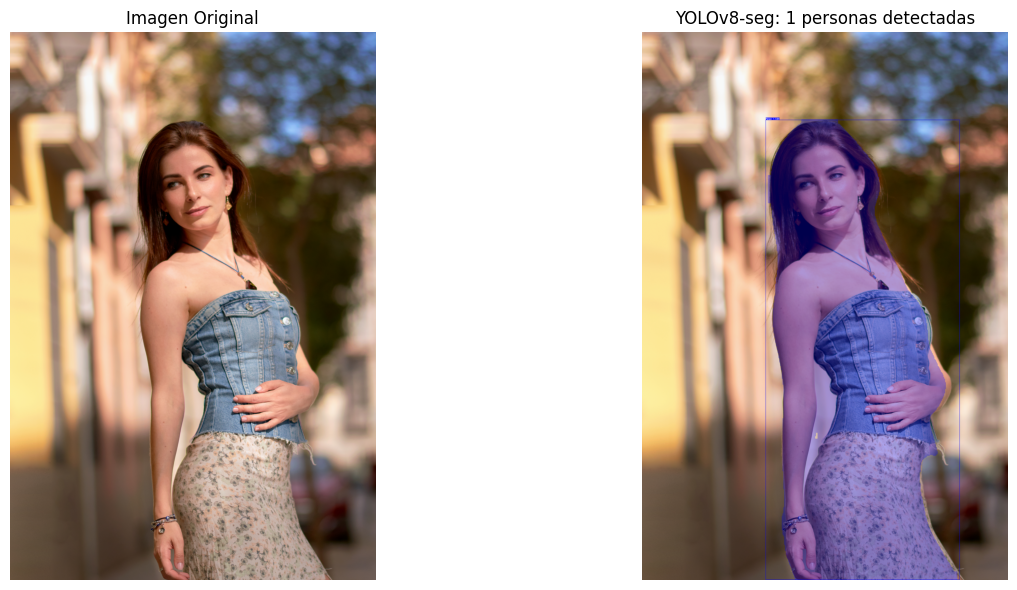

In [10]:
# Ejemplo de uso y configuración inicial
if __name__ == "__main__":
    # Inicializar modelo con configuración por defecto
    model = YOLOv8PersonSegmentation(model_size="m", confidence_threshold=0.5)

    logger.info("YOLOv8-seg inicializado correctamente")
    logger.info(f"Configuración: {model.get_model_info()}")

    # Ejemplo de uso (descomentar para probar)
    test_single_image(model, "/content/_DSC0190.jpg")
    #print(compare_model_sizes("/content/_DSC0190.jpg", ['n', 's', 'm']))

